In [1]:
! pip install colpali_engine
! pip install datasets 
! pip install huggingface_hub
! pip install qdrant-client
! pip install transformers
! pip install ollama


[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import time
import numpy as np
from qdrant_client import QdrantClient
from qdrant_client.http import models
from tqdm import tqdm
from datasets import load_dataset

c:\Users\vijit_singh\Desktop\Personal projects repo\rag-omini\orag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = load_dataset("Pran10/ColpaliTest",
                       split="train",
                       cache_dir="./hf_cache")

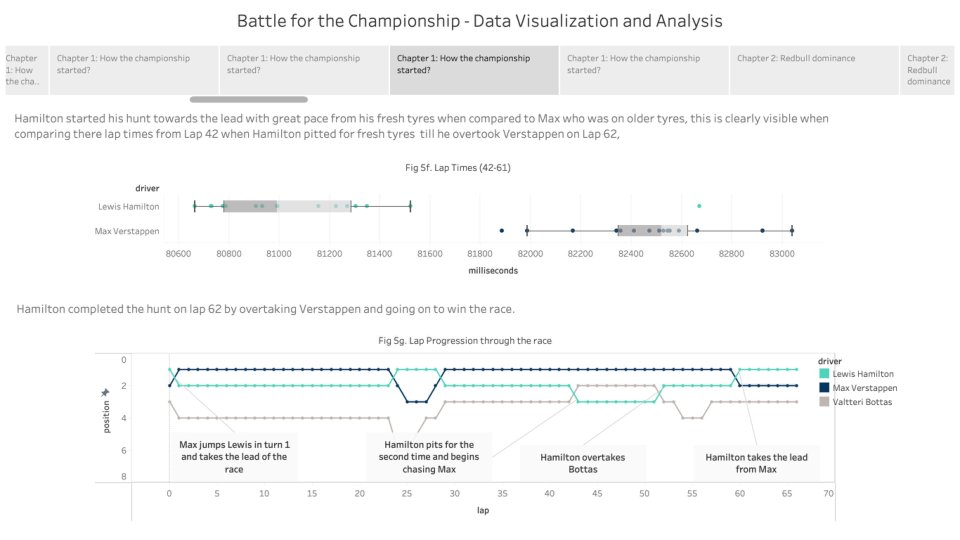

In [4]:
dataset[3]["image"]

In [5]:
import qdrant_client

client = qdrant_client.QdrantClient(
    host="localhost",
    port=6333
)

In [6]:
from colpali_engine.models import ColPali, ColPaliProcessor
import torch

model_name = "vidore/colpali-v1.2"

# Load model on CPU with float32
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.float32,  # Use float32 instead of bfloat16
    device_map=None,           # Omit device_map or set to None
    trust_remote_code=True,
    cache_dir="./hf_cache"
)

# Move model to MPS device if available
if torch.backends.mps.is_available():
    colpali_model.to('mps')

# Load processor
colpali_processor = ColPaliProcessor.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:34<00:00, 17.35s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
collection_name = "colpaili_demo"

client.create_collection(
    collection_name=collection_name,
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=128,
        distance=models.Distance.COSINE,
        on_disk=True,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
    ),
)

True

In [8]:
import base64
from io import BytesIO

def image_to_base64(image):
    buffered = BytesIO()

    image.save(buffered, format="JPEG")

    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [9]:
batch_size = 4
all_embeddings = torch.zeros(len(dataset), 128)

In [10]:
total = len(dataset)
for i in tqdm(range(0, total, batch_size), desc="Indexing Progress", total=total//batch_size + 1):

    batch = dataset[i : i + batch_size]
    images = batch["image"]

    with torch.no_grad():
        batch_images = colpali_processor.process_images(images).to(colpali_model.device)
        image_embeddings = colpali_model(**batch_images)

    points = []
    for j, embedding in enumerate(image_embeddings):
            multivector = embedding.cpu().float().numpy().tolist()

            points.append(
                models.PointStruct(
                    id=i+j,  # we just use the index as the ID
                    vector=multivector,  # This is now a list of vectors
                    payload={
                        "source": image_to_base64(dataset[i+j]["image"])
                    },
                )
            )

    try:
        client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        continue
print("Indexing complete!")

Indexing Progress: 100%|██████████| 12/12 [47:41<00:00, 238.49s/it]

Indexing complete!


In [11]:
query_text = "Which two players competed in the title fight?"

with torch.no_grad():
    query = colpali_processor.process_queries([query_text]).to(colpali_model.device)
    
    query_embedding = colpali_model(**query)

In [12]:
query_embedding

tensor([[[ 0.1654, -0.0261,  0.0932,  ..., -0.0288, -0.0715, -0.0389],
         [ 0.0246, -0.1403, -0.0330,  ...,  0.0498,  0.0054,  0.0593],
         [ 0.0356, -0.0863, -0.0332,  ..., -0.0449,  0.0654,  0.0341],
         ...,
         [ 0.0810,  0.0250, -0.0693,  ..., -0.0854,  0.1166,  0.0214],
         [ 0.0845,  0.0156, -0.0694,  ..., -0.0867,  0.1098,  0.0239],
         [ 0.0449, -0.0347, -0.1193,  ..., -0.0772,  0.0565,  0.0563]]])

In [13]:
token_query = query_embedding[0].cpu().float().numpy().tolist()

start_time = time.time()

query_result = client.query_points(collection_name=collection_name,
                                   query=token_query,
                                   limit=4,
                                   search_params=models.SearchParams(
                                   quantization=models.QuantizationSearchParams(
                                   ignore=True,
                                   rescore=True,
                                   oversampling=2.0
                                   )
                               )
                           )

print(f"Time taken = {(time.time()-start_time):.3f} s")

Time taken = 0.581 s


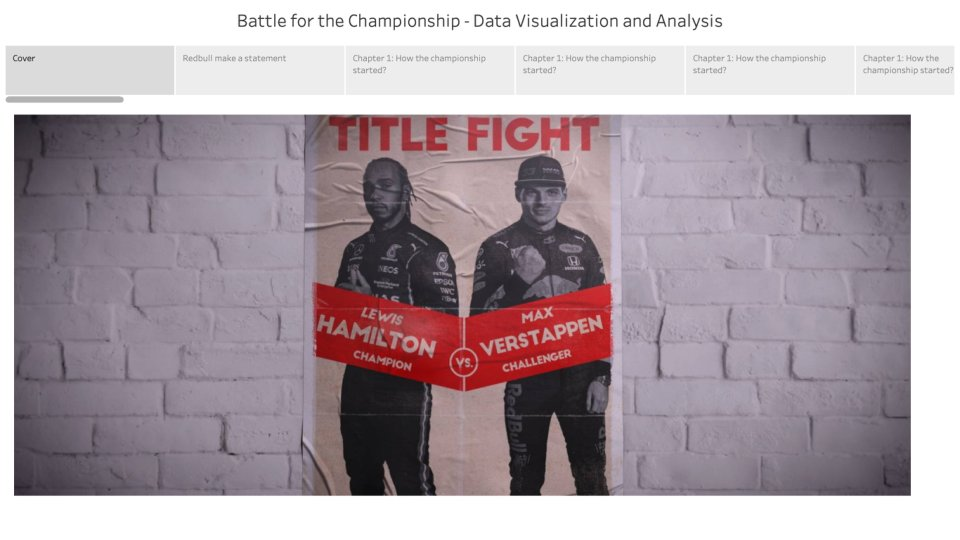

In [14]:
output_idx = query_result.points[0].id
dataset[output_idx]['image']

In [15]:
dataset[output_idx]["image"].save("temp_image.jpg")

In [16]:
qa_prompt_tmpl_str = """The user has asked the following question:

                        ---------------------
                        
                        Query: {query}
                        
                        ---------------------

                        Some images are available to you
                        for this question. You have
                        to understand these images thoroughly and 
                        extract all relevant information that might 
                        help you answer the query better.
                                     
                        Given the context information above I want you
                        to think step by step to answer the query in a
                        crisp manner, in case you don't know the
                        answer say 'I don't know!'
                                     
                        ---------------------
                        Answer: """

In [17]:
prompt = qa_prompt_tmpl_str.format(query=query_text)

messages = [{"role": "user",
             "content": prompt,
             "images": ["temp_image.jpg"]
             }]

In [19]:
import ollama
response = ollama.chat(model="llama3.2-vision",
                       messages=messages)

In [20]:
from IPython.display import Markdown

display(Markdown(response.message.content))

The two players who competed in the title fight are Lewis Hamilton and Max Verstappen.

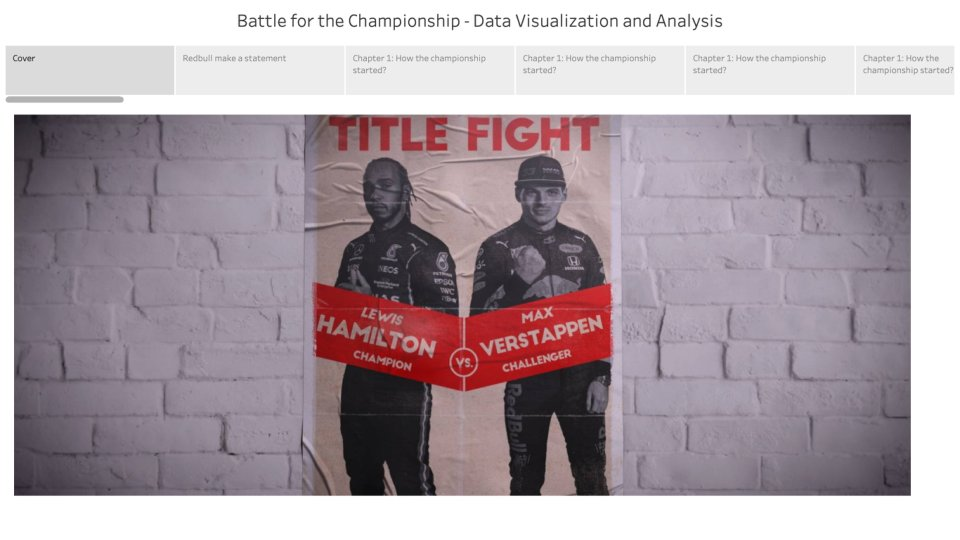

In [21]:
output_idx = query_result.points[0].id
dataset[output_idx]["image"]